In [1]:
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import pickle
from numba import jit
from tqdm import tqdm
from scipy.integrate import quad

from psiam_delay_paper_utils import simulate_psiam
from psiam_delay_paper_utils import rho_A_t_fn, cum_A_t_fn
from psiam_delay_paper_utils import rho_E_t_fn
from psiam_delay_paper_utils import rho_E_minus_small_t_NORM_fn
from psiam_delay_paper_utils import P_small_t_btn_x1_x2

# Generate data

In [40]:
V_A = 1.5; theta_A = 2; 
V_E = -1.2; theta_E = 4
Z_E = 2
t_stim = 0.5
t_A_aff = 0.01
t_E_aff = 0.03
t_motor = 0.02
dt = 1e-4

N_sim = 100000
choices = np.zeros((N_sim, 1)); RTs = np.zeros((N_sim, 1)); is_act_resp = np.zeros((N_sim, 1))


results = Parallel(n_jobs=-1)(delayed(simulate_psiam)(V_A, theta_A, V_E, theta_E, Z_E, t_stim, t_A_aff, t_E_aff, t_motor, dt) for _ in range(N_sim))

choices, RTs, is_act_resp = zip(*results)
choices = np.array(choices).reshape(-1, 1)
RTs = np.array(RTs).reshape(-1, 1)
is_act_resp = np.array(is_act_resp).reshape(-1, 1)

print(f'Num of act resp = {is_act_resp.sum()}/{N_sim}')
print(f'Number of aborts = {(RTs < t_stim).sum()}')

psiam_data = {'choices': choices, 'RTs': RTs, 'is_act_resp': is_act_resp, 'V_A': V_A, 'theta_A': theta_A, 
              'V_E': V_E, 'theta_E': theta_E, 't_stim': t_stim, 'Z_E': Z_E,
              't_A_aff': t_A_aff, 't_E_aff': t_E_aff, 't_motor': t_motor
              }


# with open('psiam_data_delay_paper_t_A_zero_t_motor_NEW_SIM_pos_vel_10_K.pkl', 'wb') as f: # _1 for t_stim = 0, _2 for non t_stim = 0.3
#     pickle.dump(psiam_data, f)

Num of act resp = 99089/100000
Number of aborts = 4523


In [41]:
# with open('psiam_data_delay_paper_1Million_t_A_zero.pkl', 'rb') as f:
#     psiam_data = pickle.load(f)


choices = psiam_data['choices']
RTs = psiam_data['RTs']
is_act_resp = psiam_data['is_act_resp']
V_A = psiam_data['V_A']
theta_A = psiam_data['theta_A']
V_E = psiam_data['V_E']
theta_E = psiam_data['theta_E']
Z_E = psiam_data['Z_E']
t_stim = psiam_data['t_stim']
t_A_aff = psiam_data['t_A_aff']
t_E_aff = psiam_data['t_E_aff']
t_motor = psiam_data['t_motor']


indices_evid = np.where(is_act_resp == 0)[0]
RTs_evid = RTs[indices_evid].flatten()

indices_act = np.where(is_act_resp == 1)[0]
RTs_act = RTs[indices_act].flatten()

RTs = RTs.flatten()


choice_up_idx = np.where(choices == 1)[0]
RTs_up = RTs[choice_up_idx]

# RTs_up > t_stim
choice_up_idx_non_abort = np.intersect1d(choice_up_idx, np.where(RTs > t_stim))
RTs_up_non_abort = RTs[choice_up_idx_non_abort]

choice_down_idx = np.where(choices == -1)[0]
RTs_down = RTs[choice_down_idx]

# RTs_down > t_stim
choice_down_idx_non_abort = np.intersect1d(choice_down_idx, np.where(RTs > t_stim))
RTs_down_non_abort = RTs[choice_down_idx_non_abort]


print(f"V_A: {V_A}")
print(f"theta_A: {theta_A}")
print(f"V_E: {V_E}")
print(f"theta_E: {theta_E}")
print(f"t stim is {t_stim}")
print(f"t_A_aff: {t_A_aff}, t_E_aff: {t_E_aff}, t_motor: {t_motor}")

print(f"Num of AI process: {is_act_resp.sum()}/{len(is_act_resp)}")
print(f'Number of aborts = {(RTs < t_stim).sum()}')

V_A: 1.5
theta_A: 2
V_E: -1.2
theta_E: 4
t stim is 0.5
t_A_aff: 0.01, t_E_aff: 0.03, t_motor: 0.02
Num of AI process: 99089/100000
Number of aborts = 4523


# Fit all RTs

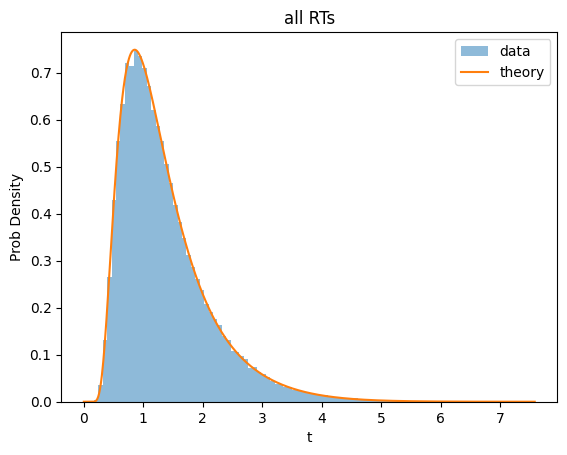

In [42]:
t_pts = np.linspace(0.001, max(RTs), 1000)
K_max = 10
P_A = [rho_A_t_fn(t-t_A_aff-t_motor, V_A, theta_A, t_A_aff, t_motor) for t in t_pts]# if AI hit
C_E = [quad(rho_E_t_fn, 0, t-t_stim, args=(V_E, theta_E, K_max, t_stim, Z_E, t_E_aff, t_motor))[0] for t in t_pts]
P_E_cum = np.zeros(len(t_pts))
for i,t in enumerate(t_pts):
    t1 = t - t_motor - t_stim - t_E_aff
    t2 = t - t_stim
    if t1 < 0:
        t1 = 0
    P_E_cum[i] = quad(rho_E_t_fn, t1, t2, args=(V_E, theta_E, K_max, t_stim, Z_E, t_E_aff, t_motor))[0]


P_E = [rho_E_t_fn(t-t_E_aff-t_stim-t_motor, V_E, theta_E, K_max, t_stim, Z_E, t_E_aff, t_motor) for t in t_pts]
C_A = [cum_A_t_fn(t-t_A_aff-t_motor, V_A, theta_A, t_A_aff, t_motor) for t in t_pts]

P_A = np.array(P_A); C_E = np.array(C_E); P_E = np.array(P_E); C_A = np.array(C_A)
P_all = P_A*((1-C_E)+P_E_cum) + P_E*(1-C_A)


plt.hist(RTs, bins=100, alpha=0.5, label='data', density=True);
plt.plot(t_pts, P_all, label='theory');
plt.legend();
plt.xlabel('t'); plt.ylabel('Prob Density');plt.title('all RTs');

# Fit correct RTs with aborts

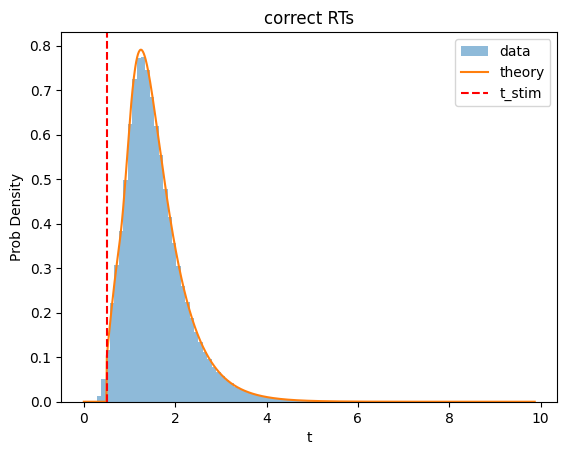

In [6]:
t_pts = np.linspace(0.001, max(RTs), 1000)
K_max = 10
P_A = [rho_A_t_fn(t-t_A_aff-t_motor, V_A, theta_A, t_A_aff, t_motor) for t in t_pts]
P_EA_btn_1_2 = [P_small_t_btn_x1_x2(1, 2, t-t_stim, V_E, theta_E, Z_E, K_max, t_stim, t_E_aff, t_motor) for t in t_pts]
P_E_plus_cum = np.zeros(len(t_pts))
for i,t in enumerate(t_pts):
    t1 = t - t_motor - t_stim - t_E_aff
    t2 = t - t_stim
    if t1 < 0:
        t1 = 0
    P_E_plus_cum[i] = quad(rho_E_minus_small_t_NORM_fn, t1, t2, args=(-V_E, theta_E, K_max, t_stim, -Z_E, t_E_aff, t_motor))[0]


P_E_plus = [rho_E_minus_small_t_NORM_fn(t-t_stim-t_E_aff-t_motor, -V_E, theta_E, K_max, t_stim, -Z_E, t_E_aff, t_motor) for t in t_pts]
C_A = [cum_A_t_fn(t-t_A_aff-t_motor, V_A, theta_A, t_A_aff, t_motor) for t in t_pts]

P_A = np.array(P_A); P_EA_btn_1_2 = np.array(P_EA_btn_1_2); P_E_plus = np.array(P_E_plus); C_A = np.array(C_A)
norm_term = len(choice_up_idx_non_abort)/len(RTs)

P_correct = (P_A*(P_EA_btn_1_2 + P_E_plus_cum) + P_E_plus*(1-C_A))/norm_term

plt.hist(RTs_up,bins=100, alpha=0.5, label='data', density=True);
plt.plot(t_pts, P_correct, label='theory');
plt.axvline(x=t_stim, label='t_stim',linestyle='--', color='r')


plt.legend();
plt.xlabel('t'); plt.ylabel('Prob Density');plt.title('correct RTs');

# Check correct norm term

In [8]:
# area under P_correct
print(f'Area under P_correct = {np.trapz(P_correct, t_pts)}')

Area under P_correct = 1.0009232695661732


In [9]:
def P_correct_norm_fn(t, V_A, theta_A, V_E, theta_E, Z_E, K_max, t_stim, t_A_aff, t_E_aff, t_motor):
    P_A = rho_A_t_fn(t-t_A_aff-t_motor, V_A, theta_A, t_A_aff, t_motor)
    P_EA_btn_1_2 = P_small_t_btn_x1_x2(1, 2, t-t_stim, V_E, theta_E, Z_E, K_max, t_stim, t_E_aff, t_motor)
    t1 = t - t_motor - t_stim - t_E_aff
    t2 = t - t_stim
    if t1 < 0:
        t1 = 0
    P_E_plus_cum = quad(rho_E_minus_small_t_NORM_fn, t1, t2, args=(-V_E, theta_E, K_max, t_stim, -Z_E, t_E_aff, t_motor))[0]


    P_E_plus = rho_E_minus_small_t_NORM_fn(t-t_stim-t_E_aff-t_motor, -V_E, theta_E, K_max, t_stim, -Z_E, t_E_aff, t_motor)
    C_A = cum_A_t_fn(t-t_A_aff-t_motor, V_A, theta_A, t_A_aff, t_motor)

    P_correct = (P_A*(P_EA_btn_1_2 + P_E_plus_cum) + P_E_plus*(1-C_A))

    return P_correct

In [10]:
K_max = 10
norm_term_numeric = quad(P_correct_norm_fn, 0, np.inf, args=(V_A, theta_A, V_E, theta_E, Z_E, K_max, t_stim, t_A_aff, t_E_aff, t_motor))[0]

In [11]:
print(f'Manual norm term = {len(choice_up_idx_non_abort)/len(RTs)}')
print(f'Numeric norm term = {norm_term_numeric}')

Manual norm term = 0.869804
Numeric norm term = 0.8705956054005405


# Fit wrong RTs with aborts

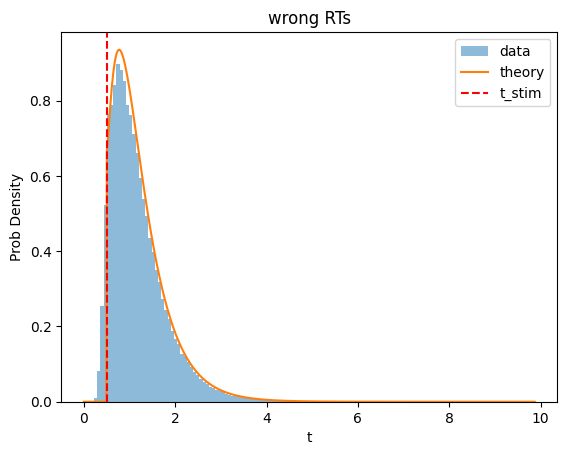

In [12]:
t_pts = np.linspace(0.001, max(RTs), 1000)
K_max = 10
P_A = [rho_A_t_fn(t-t_A_aff-t_motor, V_A, theta_A, t_A_aff, t_motor) for t in t_pts]
P_EA_btn_0_1 = [P_small_t_btn_x1_x2(0, 1, t-t_stim, V_E, theta_E, Z_E, K_max, t_stim, t_E_aff, t_motor) for t in t_pts]
P_E_minus_cum = np.zeros(len(t_pts))
for i,t in enumerate(t_pts):
    t1 = t - t_motor - t_stim - t_E_aff
    t2 = t - t_stim
    if t1 < 0:
        t1 = 0
    P_E_minus_cum[i] = quad(rho_E_minus_small_t_NORM_fn, t1, t2, args=(V_E, theta_E, K_max, t_stim, Z_E, t_E_aff, t_motor))[0]


P_E_minus = [rho_E_minus_small_t_NORM_fn(t-t_stim-t_E_aff-t_motor, V_E, theta_E, K_max, t_stim, Z_E, t_E_aff, t_motor) for t in t_pts]
C_A = [cum_A_t_fn(t-t_A_aff-t_motor, V_A, theta_A, t_A_aff, t_motor) for t in t_pts]

P_A = np.array(P_A); P_EA_btn_0_1 = np.array(P_EA_btn_0_1); P_E_minus = np.array(P_E_minus); C_A = np.array(C_A)
norm_term = len(choice_down_idx_non_abort)/len(RTs)

P_wrong = (P_A*(P_EA_btn_0_1+P_E_minus_cum) + P_E_minus*(1-C_A))/norm_term

plt.hist(RTs_down, bins=100, alpha=0.5, label='data', density=True);
plt.plot(t_pts, P_wrong, label='theory');
plt.axvline(x=t_stim, label='t_stim',linestyle='--', color='r')

plt.legend();
plt.xlabel('t'); plt.ylabel('Prob Density');plt.title('wrong RTs');

# Check Wrong nom term

In [13]:
# Area under P_wrong
print(f'Area under P_wrong = {np.trapz(P_wrong, t_pts)}')

Area under P_wrong = 0.9936691404980221


In [14]:
def wrong_norm_fn(t, V_A, theta_A, V_E, theta_E, Z_E, K_max, t_stim, t_A_aff, t_E_aff, t_motor):
    P_A = rho_A_t_fn(t-t_A_aff-t_motor, V_A, theta_A, t_A_aff, t_motor)
    P_EA_btn_0_1 = P_small_t_btn_x1_x2(0, 1, t-t_stim, V_E, theta_E, Z_E, K_max, t_stim, t_E_aff, t_motor)
    t1 = t - t_motor - t_stim - t_E_aff
    t2 = t - t_stim
    if t1 < 0:
        t1 = 0
    P_E_minus_cum = quad(rho_E_minus_small_t_NORM_fn, t1, t2, args=(V_E, theta_E, K_max, t_stim, Z_E, t_E_aff, t_motor))[0]


    P_E_minus = rho_E_minus_small_t_NORM_fn(t-t_stim-t_E_aff-t_motor, V_E, theta_E, K_max, t_stim, Z_E, t_E_aff, t_motor)
    C_A = cum_A_t_fn(t-t_A_aff-t_motor, V_A, theta_A, t_A_aff, t_motor)

    P_wrong = (P_A*(P_EA_btn_0_1 + P_E_minus_cum) + P_E_minus*(1-C_A))

    return P_wrong

In [15]:
K_max = 10
wrong_norm_numeric = quad(wrong_norm_fn, 0, np.inf, args=(V_A, theta_A, V_E, theta_E, Z_E, K_max, t_stim, t_A_aff, t_E_aff, t_motor))[0]

In [16]:
print(f'Manual norm term = {len(choice_down_idx_non_abort)/len(RTs)}')
print(f'Numeric norm term = {wrong_norm_numeric}')

Manual norm term = 0.116059
Numeric norm term = 0.11532217970215543


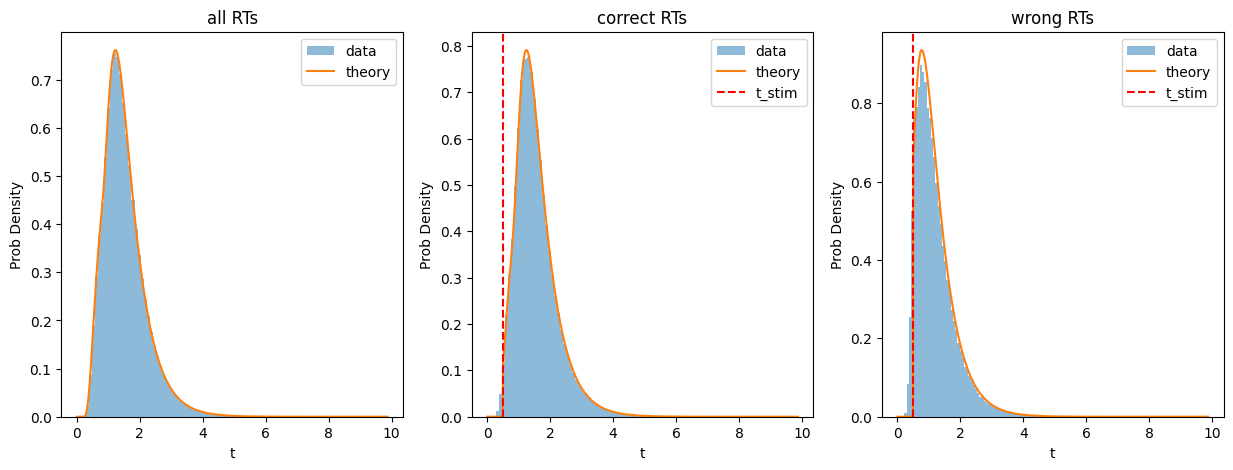

In [17]:
plt.figure(figsize=(15, 5))

plt.subplot(1,3,1)
plt.hist(RTs, bins=100, alpha=0.5, label='data', density=True);
plt.plot(t_pts, P_all, label='theory');
plt.legend();
plt.xlabel('t'); plt.ylabel('Prob Density');plt.title('all RTs');

plt.subplot(1,3,2)
plt.hist(RTs_up, bins=100, alpha=0.5, label='data', density=True);
plt.plot(t_pts, P_correct, label='theory');
plt.axvline(x=t_stim, label='t_stim',linestyle='--', color='r')
plt.legend();
plt.xlabel('t'); plt.ylabel('Prob Density');plt.title('correct RTs');

plt.subplot(1,3,3)
plt.hist(RTs_down, bins=100, alpha=0.5, label='data', density=True);
plt.plot(t_pts, P_wrong, label='theory');
plt.axvline(x=t_stim, label='t_stim',linestyle='--', color='r')
plt.legend();
plt.xlabel('t'); plt.ylabel('Prob Density');plt.title('wrong RTs');

# No aborts, fit with non-normalized theory curve

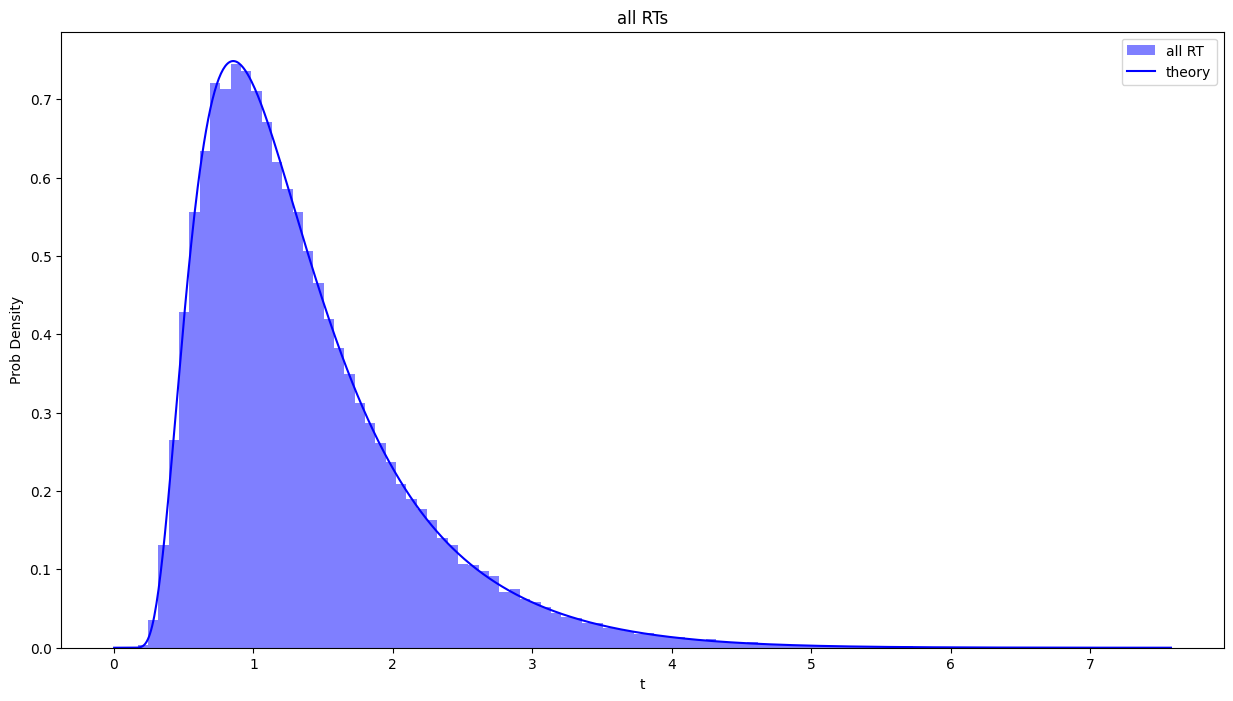

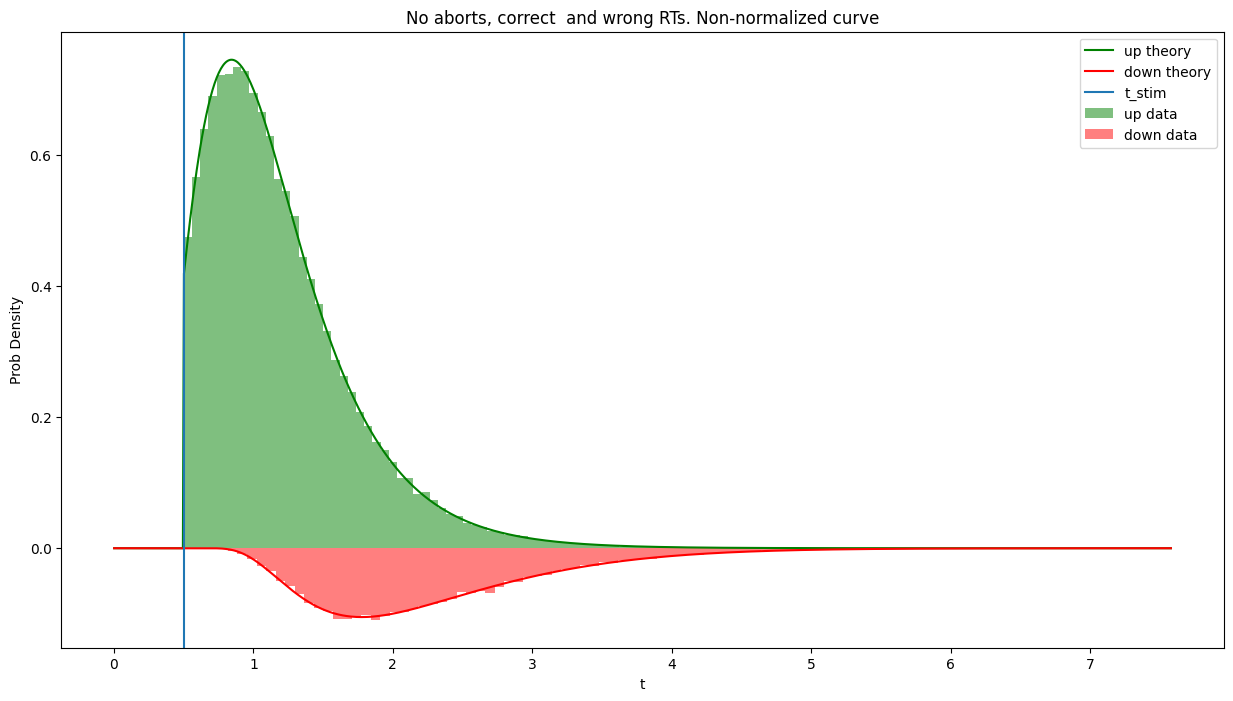

In [43]:
t_pts = np.linspace(0.001, max(RTs), 1000)



plt.figure(figsize=(15, 8))
# histogram for all
plt.hist(RTs, bins=100, alpha=0.5, label='all RT', density=True, color='b');
plt.plot(t_pts, P_all, label='theory', color='b');
plt.legend();
plt.xlabel('t'); plt.ylabel('Prob Density');plt.title('all RTs');


plt.figure(figsize=(15, 8))
# np.histogram for RTs_up
hist, bin_edges = np.histogram(RTs_up_non_abort, bins=100, density=True)
frac_of_corrects = len(RTs_up_non_abort)/len(RTs)
hist *= frac_of_corrects
bin_centers = (bin_edges[1:] + bin_edges[:-1])/2

P_A = [rho_A_t_fn(t-t_A_aff-t_motor, V_A, theta_A, t_A_aff, t_motor) for t in t_pts]
P_EA_btn_1_2 = [P_small_t_btn_x1_x2(1, 2, t-t_stim, V_E, theta_E, Z_E, K_max, t_stim, t_E_aff, t_motor) for t in t_pts]
P_E_plus_cum = np.zeros(len(t_pts))
for i,t in enumerate(t_pts):
    t1 = t - t_motor - t_stim - t_E_aff
    t2 = t - t_stim
    if t1 < 0:
        t1 = 0
    P_E_plus_cum[i] = quad(rho_E_minus_small_t_NORM_fn, t1, t2, args=(-V_E, theta_E, K_max, t_stim, -Z_E, t_E_aff, t_motor))[0]


P_E_plus = [rho_E_minus_small_t_NORM_fn(t-t_stim-t_E_aff-t_motor, -V_E, theta_E, K_max, t_stim, -Z_E, t_E_aff, t_motor) for t in t_pts]
C_A = [cum_A_t_fn(t-t_A_aff-t_motor, V_A, theta_A, t_A_aff, t_motor) for t in t_pts]

P_A = np.array(P_A); P_EA_btn_1_2 = np.array(P_EA_btn_1_2); P_E_plus = np.array(P_E_plus); C_A = np.array(C_A)
P_correct_unnorm = (P_A*(P_EA_btn_1_2 + P_E_plus_cum) + P_E_plus*(1-C_A))

plt.bar(bin_centers, hist, width=np.diff(bin_edges),label='up data', alpha=0.5, color='g');
plt.plot(t_pts, P_correct_unnorm, label='up theory', color='g');


# np.histogram for RTs_down
hist, bin_edges = np.histogram(RTs_down_non_abort, bins=100, density=True)
frac_of_wrongs = len(RTs_down_non_abort)/len(RTs)
hist *= frac_of_wrongs
bin_centers = (bin_edges[1:] + bin_edges[:-1])/2

P_A = [rho_A_t_fn(t-t_A_aff-t_motor, V_A, theta_A, t_A_aff, t_motor) for t in t_pts]
P_EA_btn_0_1 = [P_small_t_btn_x1_x2(0, 1, t-t_stim, V_E, theta_E, Z_E, K_max, t_stim, t_E_aff, t_motor) for t in t_pts]
P_E_minus_cum = np.zeros(len(t_pts))
for i,t in enumerate(t_pts):
    t1 = t - t_motor - t_stim - t_E_aff
    t2 = t - t_stim
    if t1 < 0:
        t1 = 0
    P_E_minus_cum[i] = quad(rho_E_minus_small_t_NORM_fn, t1, t2, args=(V_E, theta_E, K_max, t_stim, Z_E, t_E_aff, t_motor))[0]


P_E_minus = [rho_E_minus_small_t_NORM_fn(t-t_stim-t_E_aff-t_motor, V_E, theta_E, K_max, t_stim, Z_E, t_E_aff, t_motor) for t in t_pts]
C_A = [cum_A_t_fn(t-t_A_aff-t_motor, V_A, theta_A, t_A_aff, t_motor) for t in t_pts]

P_A = np.array(P_A); P_EA_btn_0_1 = np.array(P_EA_btn_0_1); P_E_minus = np.array(P_E_minus); C_A = np.array(C_A)
P_wrong_unnorm = (P_A*(P_EA_btn_0_1+P_E_minus_cum) + P_E_minus*(1-C_A))

plt.bar(bin_centers, -hist, width=np.diff(bin_edges),label='down data', alpha=0.5, color='r');
plt.plot(t_pts, -P_wrong_unnorm, label='down theory', color='r');
plt.axvline(x=t_stim, label='t_stim')
plt.legend();
plt.xlabel('t'); plt.ylabel('Prob Density');plt.title('No aborts, correct  and wrong RTs. Non-normalized curve');

# No aborts, fit with normalized curve

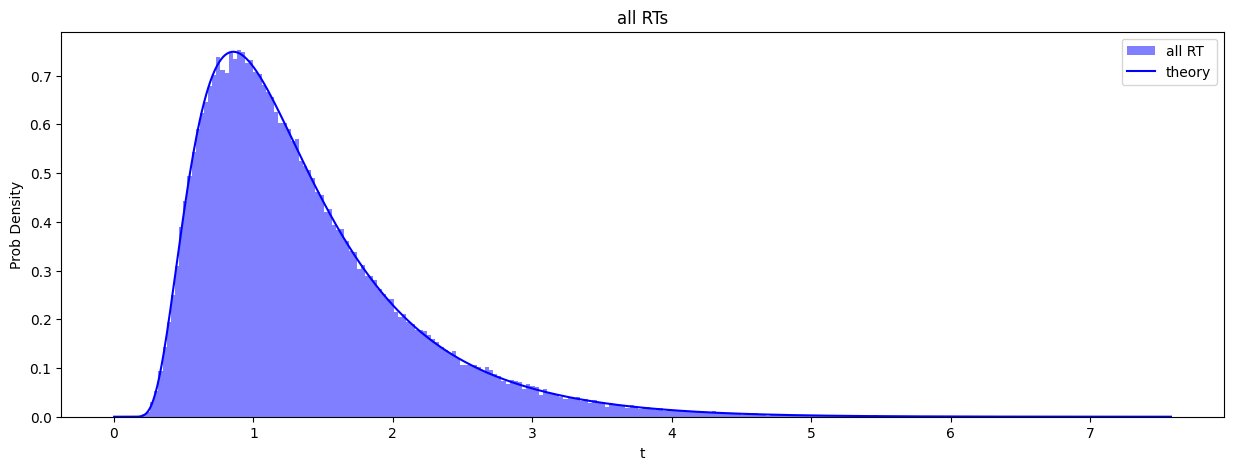

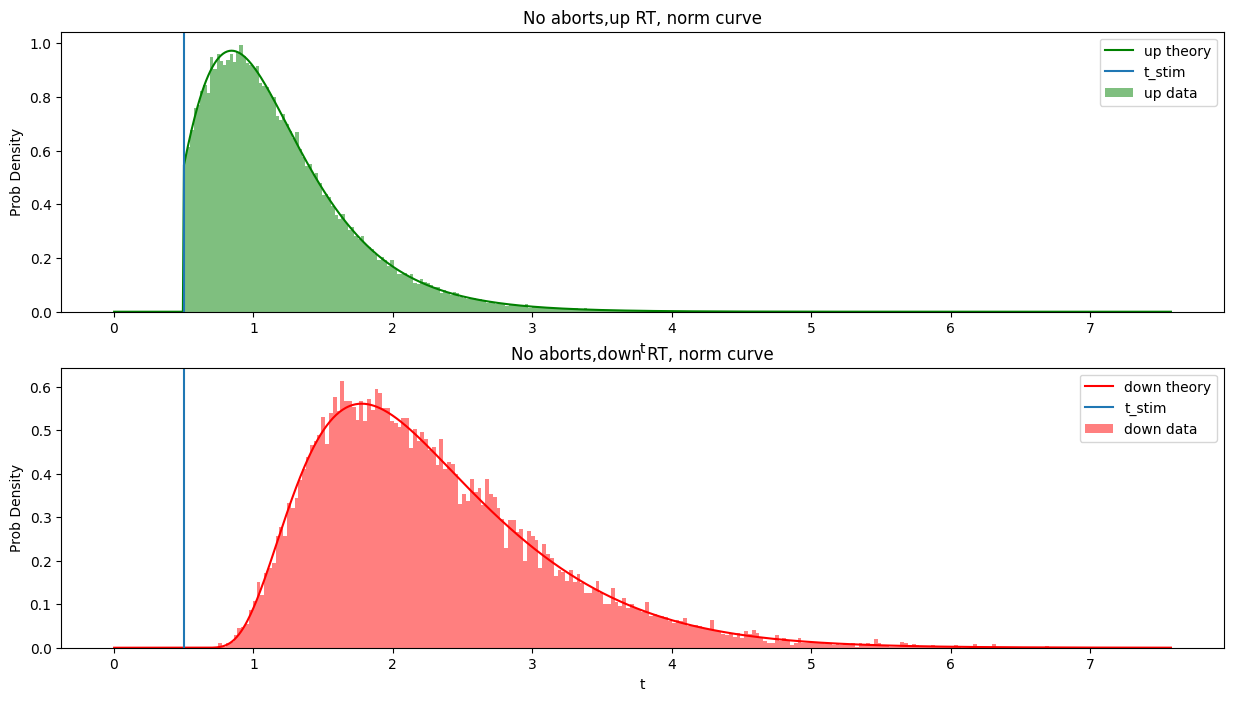

In [44]:
plt.figure(figsize=(15, 5))

# histogram for all
plt.hist(RTs, bins=250, alpha=0.5, label='all RT', density=True, color='b');
plt.plot(t_pts, P_all, label='theory', color='b');
plt.legend();
plt.xlabel('t'); plt.ylabel('Prob Density');plt.title('all RTs');

plt.figure(figsize=(15, 8))
plt.subplot(2,1,1)
# np.histogram for RTs_up
hist, bin_edges = np.histogram(RTs_up_non_abort, bins=250, density=True)
frac_of_corrects = len(RTs_up_non_abort)/len(RTs)
bin_centers = (bin_edges[1:] + bin_edges[:-1])/2

P_A = [rho_A_t_fn(t-t_A_aff-t_motor, V_A, theta_A, t_A_aff, t_motor) for t in t_pts]
P_EA_btn_1_2 = [P_small_t_btn_x1_x2(1, 2, t-t_stim, V_E, theta_E, Z_E, K_max, t_stim, t_E_aff, t_motor) for t in t_pts]
P_E_plus_cum = np.zeros(len(t_pts))
for i,t in enumerate(t_pts):
    t1 = t - t_motor - t_stim - t_E_aff
    t2 = t - t_stim
    if t1 < 0:
        t1 = 0
    P_E_plus_cum[i] = quad(rho_E_minus_small_t_NORM_fn, t1, t2, args=(-V_E, theta_E, K_max, t_stim, -Z_E, t_E_aff, t_motor))[0]


P_E_plus = [rho_E_minus_small_t_NORM_fn(t-t_stim-t_E_aff-t_motor, -V_E, theta_E, K_max, t_stim, -Z_E, t_E_aff, t_motor) for t in t_pts]
C_A = [cum_A_t_fn(t-t_A_aff-t_motor, V_A, theta_A, t_A_aff, t_motor) for t in t_pts]

P_A = np.array(P_A); P_EA_btn_1_2 = np.array(P_EA_btn_1_2); P_E_plus = np.array(P_E_plus); C_A = np.array(C_A)
P_correct_norm = (P_A*(P_EA_btn_1_2 + P_E_plus_cum) + P_E_plus*(1-C_A))/frac_of_corrects

plt.bar(bin_centers, hist, width=np.diff(bin_edges),label='up data', alpha=0.5, color='g');
plt.plot(t_pts, P_correct_norm, label='up theory', color='g');
plt.axvline(x=t_stim, label='t_stim')
plt.legend();
plt.xlabel('t'); plt.ylabel('Prob Density');plt.title('No aborts,up RT, norm curve');

# np.histogram for RTs_down
hist, bin_edges = np.histogram(RTs_down_non_abort, bins=250, density=True)
frac_of_wrongs = len(RTs_down_non_abort)/len(RTs)
bin_centers = (bin_edges[1:] + bin_edges[:-1])/2

P_A = [rho_A_t_fn(t-t_A_aff-t_motor, V_A, theta_A, t_A_aff, t_motor) for t in t_pts]
P_EA_btn_0_1 = [P_small_t_btn_x1_x2(0, 1, t-t_stim, V_E, theta_E, Z_E, K_max, t_stim, t_E_aff, t_motor) for t in t_pts]
P_E_minus_cum = np.zeros(len(t_pts))
for i,t in enumerate(t_pts):
    t1 = t - t_motor - t_stim - t_E_aff
    t2 = t - t_stim
    if t1 < 0:
        t1 = 0
    P_E_minus_cum[i] = quad(rho_E_minus_small_t_NORM_fn, t1, t2, args=(V_E, theta_E, K_max, t_stim, Z_E, t_E_aff, t_motor))[0]


P_E_minus = [rho_E_minus_small_t_NORM_fn(t-t_stim-t_E_aff-t_motor, V_E, theta_E, K_max, t_stim, Z_E, t_E_aff, t_motor) for t in t_pts]
C_A = [cum_A_t_fn(t-t_A_aff-t_motor, V_A, theta_A, t_A_aff, t_motor) for t in t_pts]

P_A = np.array(P_A); P_EA_btn_0_1 = np.array(P_EA_btn_0_1); P_E_minus = np.array(P_E_minus); C_A = np.array(C_A)
P_wrong_norm = (P_A*(P_EA_btn_0_1+P_E_minus_cum) + P_E_minus*(1-C_A))/frac_of_wrongs

plt.subplot(2,1,2)
plt.bar(bin_centers, hist, width=np.diff(bin_edges),label='down data', alpha=0.5, color='r');
plt.plot(t_pts, P_wrong_norm, label='down theory', color='r');
plt.axvline(x=t_stim, label='t_stim')
plt.legend();
plt.xlabel('t'); plt.ylabel('Prob Density');plt.title('No aborts,down RT, norm curve');

(0.1, 1.0)

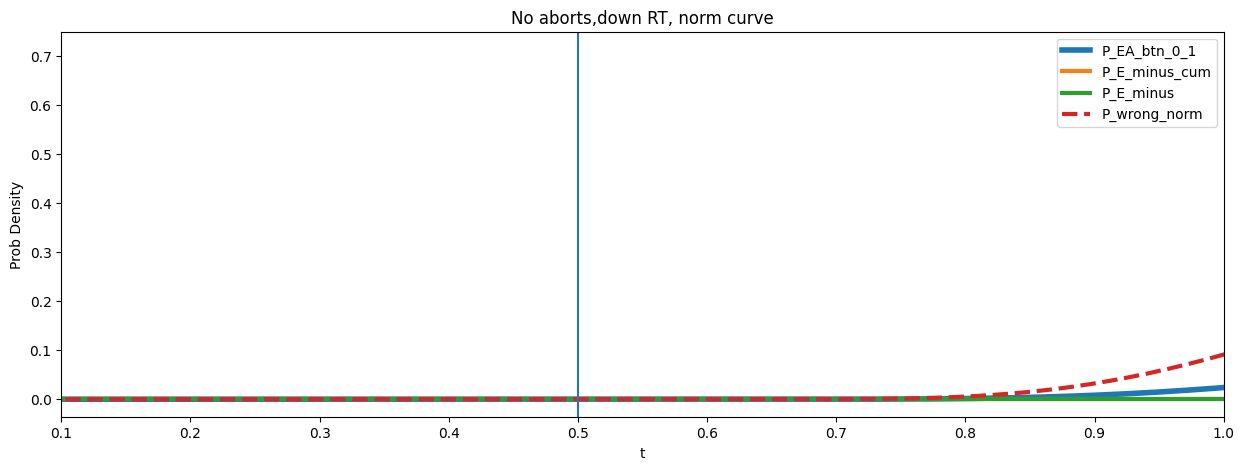

In [56]:
# P_A = [rho_A_t_fn(t-t_A_aff-t_motor, V_A, theta_A, t_A_aff, t_motor) for t in t_pts]
# P_EA_btn_0_1 = [P_small_t_btn_x1_x2(0, 1, t-t_stim, V_E, theta_E, Z_E, K_max, t_stim, t_E_aff, t_motor) for t in t_pts]
# P_E_minus_cum = np.zeros(len(t_pts))
# for i,t in enumerate(t_pts):
#     t1 = t - t_motor - t_stim - t_E_aff
#     t2 = t - t_stim
#     if t1 < 0:
#         t1 = 0
#     P_E_minus_cum[i] = quad(rho_E_minus_small_t_NORM_fn, t1, t2, args=(V_E, theta_E, K_max, t_stim, Z_E, t_E_aff, t_motor))[0]


# P_E_minus = [rho_E_minus_small_t_NORM_fn(t-t_stim-t_E_aff-t_motor, V_E, theta_E, K_max, t_stim, Z_E, t_E_aff, t_motor) for t in t_pts]
# C_A = [cum_A_t_fn(t-t_A_aff-t_motor, V_A, theta_A, t_A_aff, t_motor) for t in t_pts]

# P_A = np.array(P_A); P_EA_btn_0_1 = np.array(P_EA_btn_0_1); P_E_minus = np.array(P_E_minus); C_A = np.array(C_A)
# P_wrong_norm = (P_A*(P_EA_btn_0_1+P_E_minus_cum) + P_E_minus*(1-C_A))/frac_of_wrongs
plt.figure(figsize=(15, 5))
plt.plot(t_pts, P_EA_btn_0_1, label='P_EA_btn_0_1', lw=4);
plt.plot(t_pts, P_E_minus_cum, label='P_E_minus_cum', lw=3);
plt.plot(t_pts, P_E_minus, label='P_E_minus', lw=3);
plt.plot(t_pts, P_wrong_norm, label='P_wrong_norm', linestyle='--', lw=3);
plt.legend();
plt.xlabel('t'); plt.ylabel('Prob Density');plt.title('No aborts,down RT, norm curve');
plt.axvline(x=t_stim, label='t_stim')
plt.xlim(0.1, 1)



# AI hit RTs fit

In [34]:
def AI_RT_fit(t, V_A, theta_A, V_E, theta_E, Z_E, t_stim, t_A_aff, t_E_aff, t_motor):
    P_A = rho_A_t_fn(t-t_A_aff-t_motor, V_A, theta_A, t_A_aff, t_motor)# if AI hit
    C_E = quad(rho_E_t_fn, 0, t-t_stim, args=(V_E, theta_E, K_max, t_stim, Z_E, t_E_aff, t_motor))[0]

    t1 = t - t_motor - t_stim - t_E_aff
    t2 = t - t_stim

    if t1 < 0:
        t1 = 0
    P_E_cum = quad(rho_E_t_fn, t1, t2, args=(V_E, theta_E, K_max, t_stim, Z_E, t_E_aff, t_motor))[0]

    return P_A*((1-C_E)+P_E_cum)

In [35]:
K_max = 10
AI_norm_term = quad(AI_RT_fit, 0, np.inf, args=(V_A, theta_A, V_E, theta_E, Z_E, t_stim, t_A_aff, t_E_aff, t_motor))[0]

In [36]:
t_pts = np.linspace(0.001, max(RTs), 1000)
AI_theory = [AI_RT_fit(t, V_A, theta_A, V_E, theta_E, Z_E, t_stim, t_A_aff, t_E_aff, t_motor)/AI_norm_term for t in t_pts]

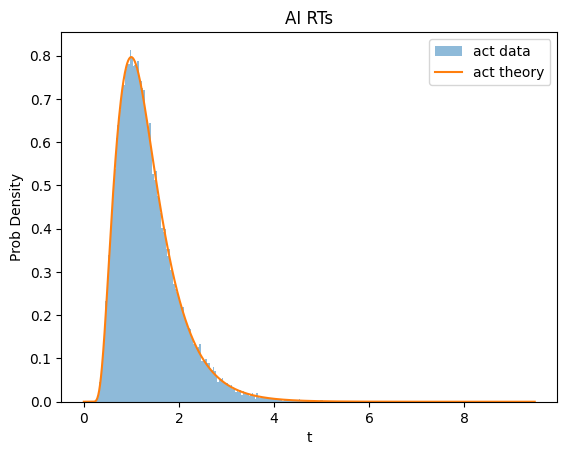

In [37]:
plt.hist(RTs_act,bins=200, alpha=0.5, label='act data', density=True);
plt.plot(t_pts, AI_theory, label='act theory');
plt.legend();
plt.xlabel('t'); plt.ylabel('Prob Density');plt.title('AI RTs');

# AI correct

In [14]:
AI_and_correct_idx = np.where((is_act_resp == 1) & (choices == 1))[0]
AI_and_correct_RT = RTs[AI_and_correct_idx]

# AI_and_correct_RT > t_stim
AI_and_correct_RT_non_abort = AI_and_correct_RT[AI_and_correct_RT > t_stim]

In [26]:
def AI_correct_fn(t, V_A, theta_A, V_E, theta_E, Z_E, t_stim, t_A_aff, t_E_aff, t_motor):
    P_A = rho_A_t_fn(t-t_A_aff-t_motor, V_A, theta_A, t_A_aff, t_motor)# if AI hit
    P_EA_btn_1_2 = P_small_t_btn_x1_x2(1, 2, t-t_stim, V_E, theta_E, Z_E, K_max, t_stim, t_E_aff, t_motor)
    t1 = t - t_motor - t_stim - t_E_aff
    t2 = t - t_stim

    if t1 < 0:
        t1 = 0
    P_E_plus_cum = quad(rho_E_minus_small_t_NORM_fn, t1, t2, args=(-V_E, theta_E, K_max, t_stim, -Z_E, t_E_aff, t_motor))[0]

    return P_A*(P_EA_btn_1_2 + P_E_plus_cum)

In [27]:
K_max = 10
AI_correct_norm = quad(AI_correct_fn, 0, np.inf, args=(V_A, theta_A, V_E, theta_E, Z_E, t_stim, t_A_aff, t_E_aff, t_motor))[0]

In [28]:
t_pts = np.linspace(0.001, max(RTs), 1000)
AI_correct_theory = [AI_correct_fn(t, V_A, theta_A, V_E, theta_E, Z_E, t_stim, t_A_aff, t_E_aff, t_motor)/AI_correct_norm for t in t_pts]

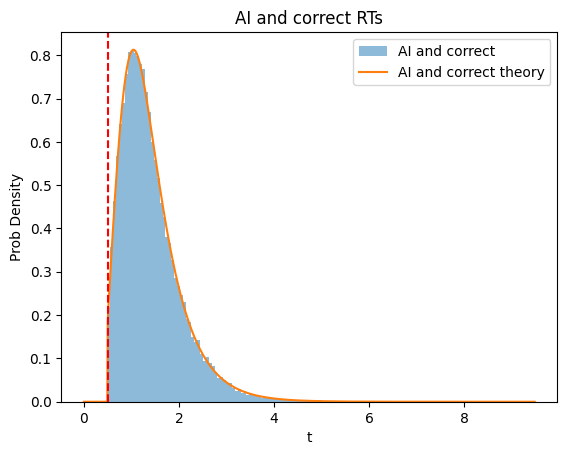

In [29]:
plt.hist(AI_and_correct_RT_non_abort, bins=100, alpha=0.5, label='AI and correct', density=True);
plt.plot(t_pts, AI_correct_theory, label='AI and correct theory');
plt.legend();
plt.axvline(x=t_stim, label='t_stim',linestyle='--', color='r')
plt.xlabel('t'); plt.ylabel('Prob Density');plt.title('AI and correct RTs');

# AI wrong RTs

In [19]:
AI_and_wrong_idx = np.where((is_act_resp == 1) & (choices == -1))[0]
AI_and_wrong_RT = RTs[AI_and_wrong_idx]

# AI_and_wrong_RT > t_stim
AI_and_wrong_RT_non_abort = AI_and_wrong_RT[AI_and_wrong_RT > t_stim]

In [20]:
def AI_wrong_fn(t, V_A, theta_A, V_E, theta_E, Z_E, t_stim, t_A_aff, t_E_aff, t_motor):
    P_A = rho_A_t_fn(t-t_A_aff-t_motor, V_A, theta_A, t_A_aff, t_motor)# if AI hit
    P_EA_btn_0_1 = P_small_t_btn_x1_x2(0, 1, t-t_stim, V_E, theta_E, Z_E, K_max, t_stim, t_E_aff, t_motor)
    t1 = t - t_motor - t_stim - t_E_aff
    t2 = t - t_stim

    if t1 < 0:
        t1 = 0
    P_E_minus_cum = quad(rho_E_minus_small_t_NORM_fn, t1, t2, args=(V_E, theta_E, K_max, t_stim, Z_E, t_E_aff, t_motor))[0]

    return P_A*(P_EA_btn_0_1 + P_E_minus_cum)

In [22]:
K_max = 10
AI_wrong_norm = quad(AI_wrong_fn, 0, np.inf, args=(V_A, theta_A, V_E, theta_E, Z_E, t_stim, t_A_aff, t_E_aff, t_motor))[0]

In [23]:
AI_wrong_theory = [AI_wrong_fn(t, V_A, theta_A, V_E, theta_E, Z_E, t_stim, t_A_aff, t_E_aff, t_motor)/AI_wrong_norm for t in t_pts]

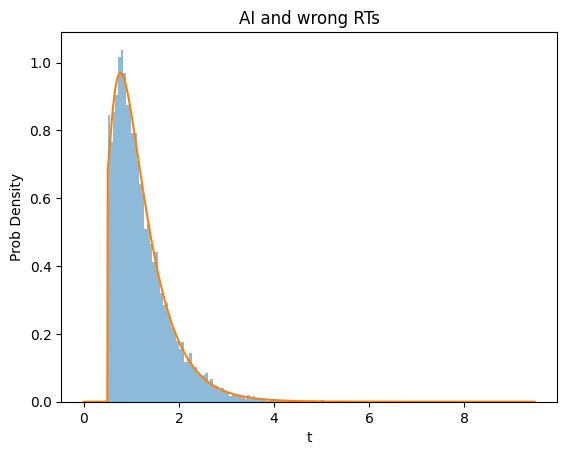

In [25]:
plt.hist(AI_and_wrong_RT_non_abort, bins=100, alpha=0.5, label='AI and wrong', density=True);
plt.plot(t_pts, AI_wrong_theory, label='AI and wrong theory');
plt.xlabel('t'); plt.ylabel('Prob Density');plt.title('AI and wrong RTs');

# Pxt 

In [65]:
t_pts = np.linspace(0.001, max(RTs)+5, 1000)
p_1_2 = [P_small_t_btn_x1_x2(1, 2, t-t_stim, 2, theta_E, Z_E, K_max, t_stim, t_E_aff, t_motor) for t in t_pts]
# p_hit_2 = [rho_E_minus_small_t_NORM_fn(t-t_stim, -V_E, theta_E, K_max, t_stim, -Z_E, t_E_aff, t_motor) for t in t_pts]
P_E_plus_cum = [quad(rho_E_minus_small_t_NORM_fn, 0, t-t_stim, args=(-V_E, theta_E, K_max, t_stim, -Z_E, t_E_aff, t_motor))[0] for t in t_pts]

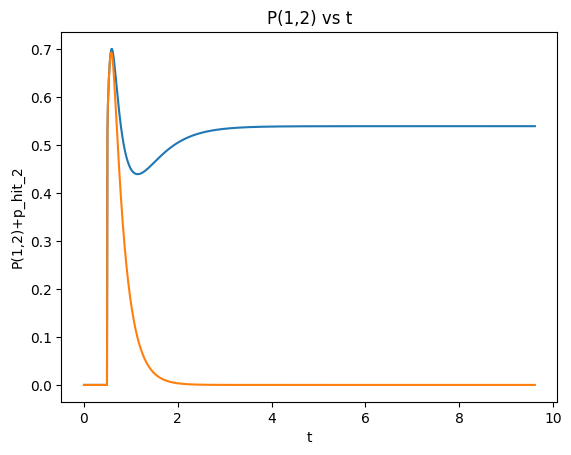

In [67]:
plt.plot(t_pts, np.array(p_1_2) + np.array(P_E_plus_cum));
plt.plot(t_pts, np.array(p_1_2));
plt.xlabel('t'); plt.ylabel('P(1,2)+p_hit_2'); plt.title('P(1,2) vs t');

# EA RT

In [39]:
def EA_RT_fit(t, V_A, theta_A, V_E, theta_E, Z_E, t_stim, t_A_aff, t_E_aff, t_motor):
    P_E = rho_E_t_fn(t-t_E_aff-t_stim-t_motor, V_E, theta_E, K_max, t_stim, Z_E, t_E_aff, t_motor)
    C_A = cum_A_t_fn(t-t_A_aff-t_motor, V_A, theta_A, t_A_aff, t_motor)
    
    return P_E*(1-C_A)

In [40]:
EA_norm_term = quad(EA_RT_fit, 0, np.inf, args=(V_A, theta_A, V_E, theta_E, Z_E, t_stim, t_A_aff, t_E_aff, t_motor))[0]

In [41]:
EA_theory =  [EA_RT_fit(t, V_A, theta_A, V_E, theta_E, Z_E, t_stim, t_A_aff, t_E_aff, t_motor)/EA_norm_term for t in t_pts]

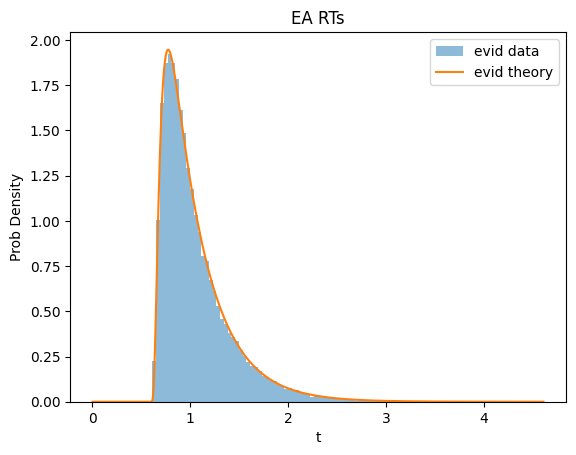

In [42]:
plt.hist(RTs_evid, bins=100, alpha=0.5, label='evid data', density=True);
plt.plot(t_pts, EA_theory, label='evid theory');
plt.legend();
plt.xlabel('t'); plt.ylabel('Prob Density');plt.title('EA RTs');

# EA correct

In [83]:
EA_correct_idx = np.where((is_act_resp == 0) & (choices == 1))[0]
EA_correct_RT = RTs[EA_correct_idx]

# t > t_stim
EA_correct_RT_non_abort = EA_correct_RT[EA_correct_RT > t_stim]

In [84]:
def EA_correct_fn(t, V_A, theta_A, V_E, theta_E, Z_E, t_stim, t_A_aff, t_E_aff, t_motor):
    P_E_plus = rho_E_minus_small_t_NORM_fn(t-t_stim-t_E_aff-t_motor, -V_E, theta_E, K_max, t_stim, -Z_E, t_E_aff, t_motor)
    C_A = cum_A_t_fn(t-t_A_aff-t_motor, V_A, theta_A, t_A_aff, t_motor)
    
    return P_E_plus*(1-C_A)

In [85]:
K_max = 10
EA_correct_norm = quad(EA_correct_fn, 0, np.inf, args=(V_A, theta_A, V_E, theta_E, Z_E, t_stim, t_A_aff, t_E_aff, t_motor))[0]

In [86]:
t_pts = np.linspace(0.001, max(RTs), 1000)
EA_correct_theory = [EA_correct_fn(t, V_A, theta_A, V_E, theta_E, Z_E, t_stim, t_A_aff, t_E_aff, t_motor)/EA_correct_norm for t in t_pts]

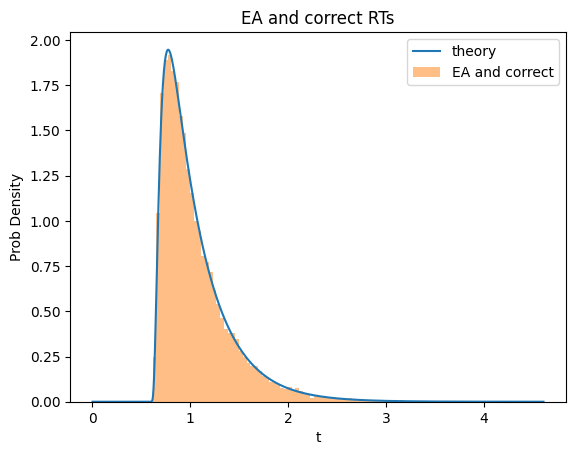

In [90]:
plt.plot(t_pts, EA_correct_theory, label='theory');
plt.hist(EA_correct_RT_non_abort, bins=100, alpha=0.5, label='EA and correct', density=True);
plt.legend();
plt.xlabel('t'); plt.ylabel('Prob Density');plt.title('EA and correct RTs');

# Checking t = t_stim, P_correct and P_Wrong

In [7]:
K_max = 10
def up_RTs_fit_fn(t_pts, V_A, theta_A, V_E, theta_E, Z_E, t_stim, t_A_aff, t_E_aff, t_motor):
    P_A = [rho_A_t_fn(t-t_A_aff-t_motor, V_A, theta_A, t_A_aff, t_motor) for t in t_pts]
    P_EA_btn_1_2 = [P_small_t_btn_x1_x2(1, 2, t-t_stim, V_E, theta_E, Z_E, K_max, t_stim, t_E_aff, t_motor) for t in t_pts]
    P_E_plus_cum = np.zeros(len(t_pts))
    for i,t in enumerate(t_pts):
        t1 = t - t_motor - t_stim - t_E_aff
        t2 = t - t_stim
        if t1 < 0:
            t1 = 0
        P_E_plus_cum[i] = quad(rho_E_minus_small_t_NORM_fn, t1, t2, args=(-V_E, theta_E, K_max, t_stim, -Z_E, t_E_aff, t_motor))[0]


    P_E_plus = [rho_E_minus_small_t_NORM_fn(t-t_stim-t_E_aff-t_motor, -V_E, theta_E, K_max, t_stim, -Z_E, t_E_aff, t_motor) for t in t_pts]
    C_A = [cum_A_t_fn(t-t_A_aff-t_motor, V_A, theta_A, t_A_aff, t_motor) for t in t_pts]

    P_A = np.array(P_A); P_EA_btn_1_2 = np.array(P_EA_btn_1_2); P_E_plus = np.array(P_E_plus); C_A = np.array(C_A)
    P_correct_unnorm = (P_A*(P_EA_btn_1_2 + P_E_plus_cum) + P_E_plus*(1-C_A))
    return P_correct_unnorm


def down_RTs_fit_fn(t_pts, V_A, theta_A, V_E, theta_E, Z_E, t_stim, t_A_aff, t_E_aff, t_motor):
    P_A = [rho_A_t_fn(t-t_A_aff-t_motor, V_A, theta_A, t_A_aff, t_motor) for t in t_pts]
    P_EA_btn_0_1 = [P_small_t_btn_x1_x2(0, 1, t-t_stim, V_E, theta_E, Z_E, K_max, t_stim, t_E_aff, t_motor) for t in t_pts]
    P_E_minus_cum = np.zeros(len(t_pts))
    for i,t in enumerate(t_pts):
        t1 = t - t_motor - t_stim - t_E_aff
        t2 = t - t_stim
        if t1 < 0:
            t1 = 0
        P_E_minus_cum[i] = quad(rho_E_minus_small_t_NORM_fn, t1, t2, args=(V_E, theta_E, K_max, t_stim, Z_E, t_E_aff, t_motor))[0]


    P_E_minus = [rho_E_minus_small_t_NORM_fn(t-t_stim-t_E_aff-t_motor, V_E, theta_E, K_max, t_stim, Z_E, t_E_aff, t_motor) for t in t_pts]
    C_A = [cum_A_t_fn(t-t_A_aff-t_motor, V_A, theta_A, t_A_aff, t_motor) for t in t_pts]

    P_A = np.array(P_A); P_EA_btn_0_1 = np.array(P_EA_btn_0_1); P_E_minus = np.array(P_E_minus); C_A = np.array(C_A)
    P_wrong_unnorm = (P_A*(P_EA_btn_0_1+P_E_minus_cum) + P_E_minus*(1-C_A))
    return P_wrong_unnorm

# aborts fit

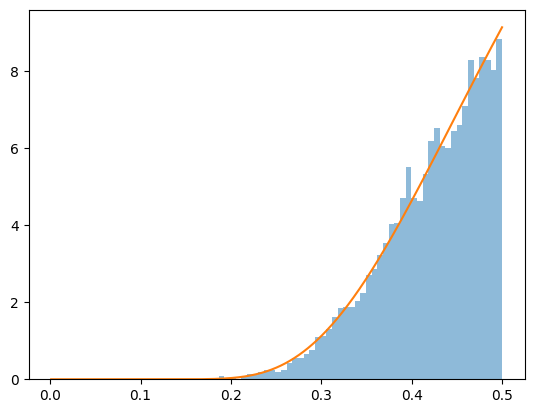

In [16]:
plt.hist(RTs[RTs < t_stim], bins=50, alpha=0.5, label='data', density=True);

t_pts = np.linspace(0.001, t_stim, 1000)
theory_abort = np.array([rho_A_t_fn(t-t_A_aff-t_motor, V_A, theta_A, t_A_aff, t_motor) for t in t_pts])

from scipy.integrate import quad
norm_term = quad(rho_A_t_fn, 0, t_stim-t_A_aff-t_motor, args=(V_A, theta_A, t_A_aff, t_motor))[0]

plt.plot(t_pts, theory_abort/norm_term, label='theory');